# Глубокое обучение в компьютерном зрении. Интерактивный курс
## Продвинутые архитектуры свёрточных нейросетей
### Обучить СНС с помощью Transfer Learning на датасете Food-101 
### Использовать тонкую настройку существующей предобученной модели и методы аугментации данных  
### Библиотеки: [Python, Tensorflow]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import PIL.Image

In [2]:
(train_ds, test_ds), ds_info = tfds.load('food101',
                                          as_supervised=True,
                                          with_info=True,
                                          split=['train[:90%]', 'train[90%:]']
                                          )

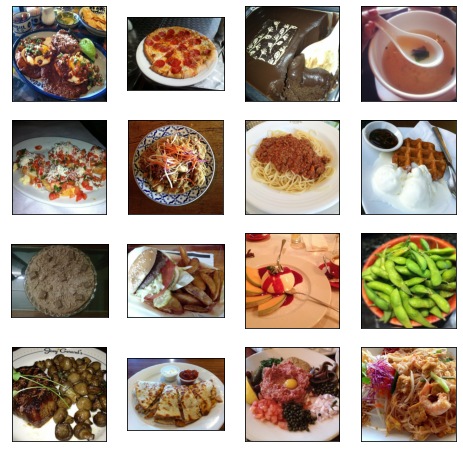

In [3]:
some_samples = [x[0] for x in iter(train_ds.take(16))]

fig = plt.figure(figsize=(8, 8))
for i in range(len(some_samples)):
  ax = fig.add_subplot(4, 4, i+1)
  ax.imshow(some_samples[i])
  plt.xticks([]), plt.yticks([])
plt.show()

In [4]:
INP_SIZE = 160
NUM_EPOCHS = 5
BATCH_SIZE = 32

def prepare(img, label):
  img = tf.cast(img, tf.float32) / 127. - 1
  return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

def augment(img, label):
  img = tf.image.flip_left_right(img)
  return img, label

train_ds = train_ds.map(prepare)
augm = train_ds.map(augment)
train_ds = train_ds.concatenate(augm)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.map(prepare)
test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.batch(128, drop_remainder=True)

In [5]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=[INP_SIZE, INP_SIZE, 3],
    include_top=False,
    weights='imagenet'
)

base_model.trainable=True

model = tf.keras.Sequential(
    [base_model,
     tf.keras.layers.GlobalAveragePooling2D(),
     tf.keras.layers.Dense(101, activation='softmax')
     ]
)

In [6]:
LEARNING_RATE = 0.0001

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

model.compile(
    optimizer=optimizer, 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = 'logs',
    write_graph=False,
    update_freq=100,
    profile_batch=0
)

In [7]:
history = model.fit(train_ds,
                    epochs=NUM_EPOCHS,
                    validation_data=test_ds,
                    callbacks=[tensorboard_callback]
                    )

Epoch 1/5
4260/4260 [==============================] - 765s 176ms/step - loss: 1.7104 - accuracy: 0.5699 - val_loss: 1.4558 - val_accuracy: 0.6226
Epoch 2/5
4260/4260 [==============================] - 760s 178ms/step - loss: 0.8870 - accuracy: 0.7582 - val_loss: 1.5059 - val_accuracy: 0.6298
Epoch 3/5
4260/4260 [==============================] - 752s 176ms/step - loss: 0.5604 - accuracy: 0.8420 - val_loss: 1.4061 - val_accuracy: 0.6576
Epoch 4/5
4260/4260 [==============================] - 746s 175ms/step - loss: 0.3593 - accuracy: 0.8979 - val_loss: 1.6274 - val_accuracy: 0.6261
Epoch 5/5
4260/4260 [==============================] - 745s 174ms/step - loss: 0.2443 - accuracy: 0.9295 - val_loss: 1.7212 - val_accuracy: 0.6486


In [14]:
model.evaluate(test_ds)

59/59 [==============================] - 26s 339ms/step - loss: 1.7213 - accuracy: 0.6490


[1.7213274240493774, 0.6489671468734741]

In [15]:
%load_ext tensorboard
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

In [16]:
!wget https://www.freestockimages.ru/food?pgid=iv2jr7b0-2c4af9f3-e197-4e0f-8a0f-d264b3ade3eb
!wget https://www.freestockimages.ru/food?pgid=iv2jr7b0-bd1a10f3-edbb-4186-9c1e-a9902117a389
!wget https://www.freestockimages.ru/food?pgid=iv2jr7b0-39953a9f-93cc-4009-8419-8b069039cb8c

--2022-08-05 18:41:38--  https://www.freestockimages.ru/food?pgid=iv2jr7b0-2c4af9f3-e197-4e0f-8a0f-d264b3ade3eb
Resolving www.freestockimages.ru (www.freestockimages.ru)... 151.101.1.84, 151.101.65.84, 151.101.129.84, ...
Connecting to www.freestockimages.ru (www.freestockimages.ru)|151.101.1.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘food?pgid=iv2jr7b0-2c4af9f3-e197-4e0f-8a0f-d264b3ade3eb’

food?pgid=iv2jr7b0-     [  <=>               ] 915.25K  1.61MB/s    in 0.6s    

2022-08-05 18:41:39 (1.61 MB/s) - ‘food?pgid=iv2jr7b0-2c4af9f3-e197-4e0f-8a0f-d264b3ade3eb’ saved [937214]

--2022-08-05 18:41:39--  https://www.freestockimages.ru/food?pgid=iv2jr7b0-bd1a10f3-edbb-4186-9c1e-a9902117a389
Resolving www.freestockimages.ru (www.freestockimages.ru)... 151.101.1.84, 151.101.65.84, 151.101.129.84, ...
Connecting to www.freestockimages.ru (www.freestockimages.ru)|151.101.1.84|:443... connected.
HTTP request sent, awaiting re

And for eating is: apple_pie


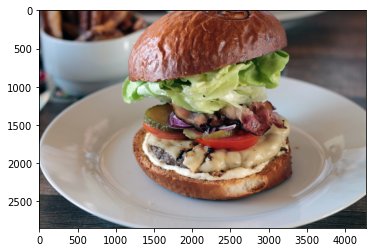

In [20]:
import imageio
from skimage.transform import resize

def prepare_image(img):
    img = img.astype(np.float32)/127. - 1.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

img = imageio.imread('/content/hamburger.jpg', pilmode="RGB")
plt.imshow(img)
img = prepare_image(img)

pred = model(img[None, ...], training=False)

pred_label = int(pred.numpy()[0][0] > 0.5)
print('And for eating is: {}'.format(ds_info.features['label'].int2str(pred_label)))

And for eating is: apple_pie


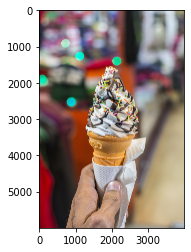

In [21]:
img = imageio.imread('/content/icecream.jpg', pilmode="RGB")
plt.imshow(img)
img = prepare_image(img)

pred = model(img[None, ...], training=False)

pred_label = int(pred.numpy()[0][0] > 0.5)
print('And for eating is: {}'.format(ds_info.features['label'].int2str(pred_label)))

And for eating is: apple_pie


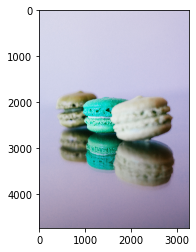

In [22]:
img = imageio.imread('/content/macarons.jpg', pilmode="RGB")
plt.imshow(img)
img = prepare_image(img)

pred = model(img[None, ...], training=False)

pred_label = int(pred.numpy()[0][0] > 0.5)
print('And for eating is: {}'.format(ds_info.features['label'].int2str(pred_label)))